### ep3-julia: logistic regression

### Logistic regression

We will use the formulation described in the textbook (<i>Learning from data</i>, Abu-Mostafa <i>et al.</i>). Positive class label equals +1 and negative equals -1.

The loss (or error) function to be minimized is
$$
E_{in}(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^{N} \ln(1 + e^{-y^{(i)} \mathbf{w}^T \mathbf{x}^{(i)}}) \tag{1}
$$

Its (ascent) gradient (the minus sign in the formula is correct!) is given by

$$\nabla E_{in}(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^{N} \frac{y^{(i)} \mathbf{x}^{(i)}}{1 + e^{y^{(i)} \mathbf{w}^T \mathbf{x}^{(i)}}}  \tag{2}$$

The logistic (sigmoid) function is
$$\sigma(z) = \frac{1}{1 + e^{-z}}  \tag{3}$$

In [2]:
# libraries
using Flux, Flux.Data.MNIST   # the julia ml library
using Images                  # image processing and machine vision for julia
using MLJ                     # make_blobs

using LinearAlgebra    # pinv pseudo-inverse matrix
using Metrics          # r2-score
using Random
using StatsBase        # standardize (normalization)
using Distributions

using Plots; gr()
using Printf

using CSV
using DataFrames


In [2]:
function crossEntropyLoss(w, X, y)
    xpn = -y .* (X * w)
    res = log.(1 .+ exp.(xpn))
    loss = mean(res)
end

# teste da função
X_teste = [1 2 4;
           3 2 6;
           7 9 3;
           12 1 7]
N, d = size(X_teste)

y_teste = [1;
           -1;
           -1;
           1]

rng = Random.seed!(1)            # generate seed
w_teste = randn(rng, d)          # generate initial w vector
display(w_teste)

crossEntropyLoss(w_teste, X_teste, y_teste)


3-element Array{Float64,1}:
  0.2972879845354616
  0.3823959677906078
 -0.5976344767282311

1.5673053843772515

In [3]:
# computes the gradient (ascent)
# Note: gradient descent = - gradient ascent
function crossEntropyGradient(w, X, y)
    xpn = -y .* (X * w)

    numerator = (y .* X)
    denominator = 1 .+ exp.(xpn)
    res = numerator ./ denominator
    grad = -mean(res, dims=1)'
end

# teste da função
crossEntropyGradient(w_teste, X_teste, y_teste)

3×1 Adjoint{Float64,Array{Float64,2}}:
 -0.6820705486989405
  0.274139435204393
  0.3446304039513245

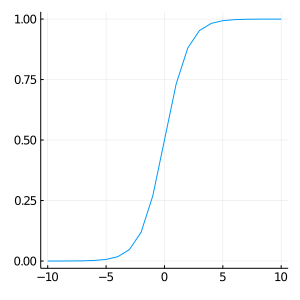

In [4]:
sigmoid(z) = 1 ./ (1 .+ exp.(-z))

# teste da função
a = -10:10
b = sigmoid(a)
plot(a, b, legend=false, size=(300,300))

In [5]:
function trainLogistic(X, y, learningRate, epochs)

    N, d = size(X)
    Xe = hcat(ones(N), X)      # add ones to first column

    w0 = randn(rng, d+1)       # generate random initial w vector

    wt = copy(w0)
    wHistory = Vector{Matrix{Float64}}()
    crossEntropyLossHistory = []         # = Vector{Float64}()
    
    for t in 1:epochs
        loss_t = crossEntropyLoss(wt, Xe, y)   # calculate the error
        
        push!(wHistory, wt')
        push!(crossEntropyLossHistory, loss_t)
        
        gt = crossEntropyGradient(wt, Xe, y)   # get the gradient
        vt = -gt                                 # get the descent gradient
        wt = wt + learningRate .* vt            # compute the weight
    end
    
    w = wHistory[argmin(crossEntropyLossHistory)]'   # get the final weight which equals minimum error
    
    return (w, wHistory, crossEntropyLossHistory)
end

# teste da função
rng = Random.seed!(1)      # generate seed
wLogistic, wHistory, crossEntropyLossHistory = trainLogistic(X_teste, y_teste, 0.1, 10)
#display(w_logistic)
#display(w_history)
display(crossEntropyLossHistory)

10-element Array{Any,1}:
 0.4748699742417804
 0.5153101169249195
 0.5798172479514497
 0.6720009947318606
 0.7984450597539234
 0.9627083809050785
 1.1642622972896224
 1.4011684758873388
 1.6706429004046897
 1.9677332315040732

In [6]:
function predictLogistic(w, X)
    N  = size(X)[1]
    Xe = hcat(ones(N), X)
    p  = sigmoid(Xe * w)
end

# teste da função
rng = Random.seed!(1)
w_teste = randn(rng, d+1)

predictLogistic(w_teste, X_teste)

4-element Array{Float64,1}:
 0.3641571399731337
 0.5464991148634797
 0.08046940511407985
 0.9854468597627305

### Example project - blob data

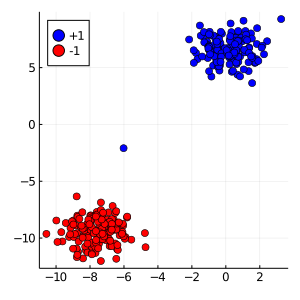

In [7]:
N = 300
X, y = make_blobs(N, 2; centers=2, cluster_std = 1, rng=6)
X = DataFrame(X) |> Array
y[ y .== 2 ] .= -1
y = y |> Array
y = y .|> Float64

Plots.scatter(X[y .== 1, 1], X[y .== 1, 2], markercolor = "blue", label = "+1", legend = :topleft, size=(300,300))
Plots.scatter!(X[y .== -1, 1], X[y .== -1, 2],  markercolor = "red",  label = "-1")

Iteração p/ erro mínimo: 424
Erro mínimo: 0.03275285512286564
Weight para erro mínimo: [0.2562389199934523; 1.2267486757200876; 0.8365797097775994]


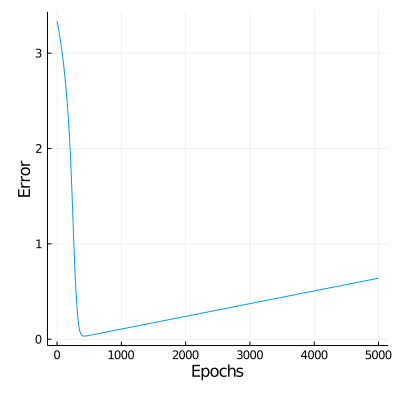

In [8]:
learningRate = 1e-3
epochs = 5000

rng = Random.seed!(1)
wl, wHistory, lossHistory = trainLogistic(X, y, learningRate, epochs)
ind = argmin(lossHistory)

println("Iteração p/ erro mínimo: ", ind)
println("Erro mínimo: ", lossHistory[ind])
println("Weight para erro mínimo: ", wl)

plot(1:epochs, lossHistory, legend=false, xlabel = "Epochs", ylabel = "Error", size=(400,400))

In [9]:
function p_to_y(p, threshold = 0.5)
    ŷ = [ (i > threshold ? 1 : -1) for i in p]
    ŷ = vec(ŷ)  # transforma array (N,1) em (N,)
end

p = predictLogistic(wl, X)
ŷ = p_to_y(p)
size(ŷ)

(300,)

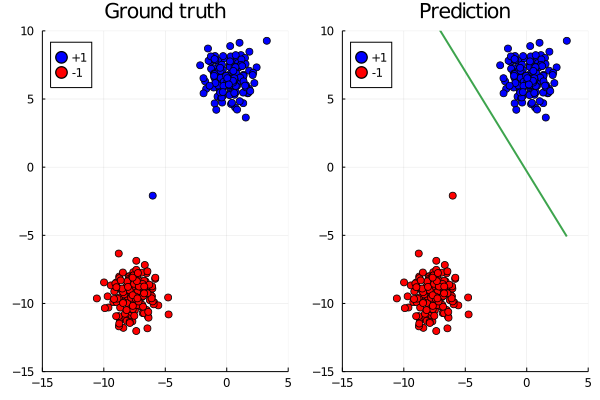

In [10]:
xl = (-15, 5)
yl = (-15, 10)

# ground truth plot
p1 = Plots.scatter(X[y .== 1, 1], X[y .== 1, 2], markercolor = "blue", label = "+1")
p1 = Plots.scatter!(X[y .== -1, 1], X[y .== -1, 2],  markercolor = "red",  label = "-1")
p1 = title!("Ground truth")

# prediction plot
p2 = Plots.scatter(X[ŷ .== 1, 1], X[ŷ .== 1, 2], markercolor = "blue", label = "+1")
p2 = Plots.scatter!(X[ŷ .== -1, 1], X[ŷ .== -1, 2],  markercolor = "red",  label = "-1")
p2 = title!("Prediction")

# add hyperplane to prediction plot
x1min = minimum(X[:,1])   # min() max() não funciona com arrays, apenas com listas
x1max = maximum(X[:,1])
x2min = minimum(X[:,2])
x2max = maximum(X[:,2])

d1 = (x1min, -(wl[1] + (x1min)*wl[2])/wl[3])
d2 = (x1max, -(wl[1] + (x1max)*wl[2])/wl[3])
p2 = plot!([d1, d2], width=2, label=false)   # plot de linha ligando d1 a d2

# show all plots
plot(p1, p2, layout=(1,2), legend=:topleft, xlims = xl, ylims = yl)

### Example project - class data

In [11]:
# read dataframe
df = CSV.File("QT1data.csv") |> DataFrame
println(first(df, 5))


5×6 DataFrame
 Row │ Sex      Age    Height  Weight  Shoe number  Trouser number 
     │ String7  Int64  Int64   Int64   Int64        String3        
─────┼─────────────────────────────────────────────────────────────
   1 │ Female      53     154      59           36  40
   2 │ Male        23     170      56           40  38
   3 │ Female      23     167      63           37  40
   4 │ Male        21     178      78           40  40
   5 │ Female      25     153      58           36  38


In [12]:
# get statistics summary
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Sex,,Female,,Male,0,String7
2,Age,28.2385,3,23.0,62,0,Int64
3,Height,170.685,100,172.0,194,0,Int64
4,Weight,70.2385,15,69.5,130,0,Int64
5,Shoe number,39.5077,24,40.0,46,0,Int64
6,Trouser number,,12,,S,0,String3


In [13]:
# get predictors of interest
feature_cols = ["Height", "Weight"]
X = df[:, feature_cols] |> Array .|> Float64
display(ismissing(X))   # get NA's
display(size(X))

# standardize predictors
X = StatsBase.standardize(ZScoreTransform, X, dims=1)

# get outcome
sex = df.Sex
display(unique(sex))
y = [ i == "Male" ? 1 : -1 for i in sex ];


false

(130, 2)

2-element Array{String7,1}:
 "Female"
 "Male"

0.45482867313329955


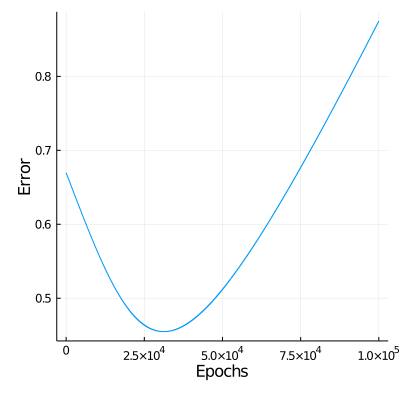

In [14]:
# train the model
learningRate = 1e-4
epochs = 100000
d = size(y)[1] + 1

rng = Random.seed!(1)      # generate seed
w, wHistory, lossHistory = trainLogistic(X, y, learningRate, epochs)
println(minimum(lossHistory))
plot(1:epochs, lossHistory, legend=false, xlabel = "Epochs", ylabel = "Error", size=(400,400))


In [15]:
# predict outcome
p = predictLogistic(wl, X)
ŷ = p_to_y(p);

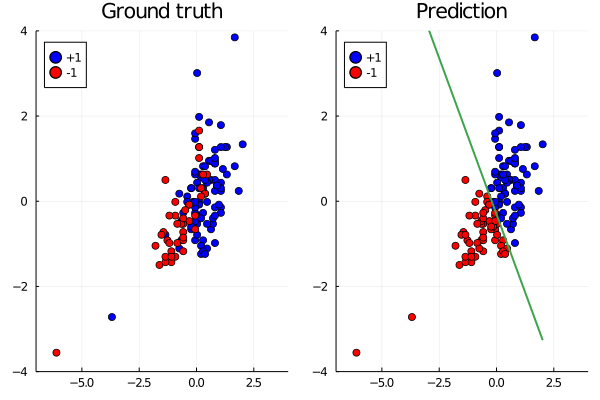

In [16]:
xl = (-7, 4)
yl = (-4, 4)

# ground truth plot
p1 = Plots.scatter(X[y .== 1, 1], X[y .== 1, 2], markercolor = "blue", label = "+1")
p1 = Plots.scatter!(X[y .== -1, 1], X[y .== -1, 2],  markercolor = "red",  label = "-1")
p1 = title!("Ground truth")

# prediction plot
p2 = Plots.scatter(X[ŷ .== 1, 1], X[ŷ .== 1, 2], markercolor = "blue", label = "+1")
p2 = Plots.scatter!(X[ŷ .== -1, 1], X[ŷ .== -1, 2],  markercolor = "red",  label = "-1")
p2 = title!("Prediction")

# add hyperplane to prediction plot
x1min = minimum(X[:,1])   # min() max() não funciona com arrays, apenas com listas
x1max = maximum(X[:,1])
x2min = minimum(X[:,2])
x2max = maximum(X[:,2])

d1 = (x1min, -(wl[1] + (x1min)*wl[2])/wl[3])
d2 = (x1max, -(wl[1] + (x1max)*wl[2])/wl[3])
p2 = plot!([d1, d2], width=2, label=false)   # plot de linha ligando d1 a d2

# show all plots
plot(p1, p2, layout=(1,2), legend=:topleft, xlims=xl, ylims=yl)

### Example project - mnist

In [3]:
# load mnist from Flux
labels = MNIST.labels()
images = MNIST.images()

display(length(images))
display(length(labels))


60000

60000

,,,,

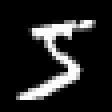
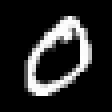
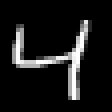
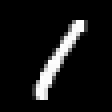
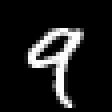

1×5 Adjoint{Int64,Array{Int64,1}}:
 5  0  4  1  9

In [4]:
display(images[1:5])
labels[1:5]'

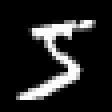

(28, 28)

784

In [5]:
display(images[1])
display(size(images[1]))
length(images[1])

In [6]:
# numeric representation of image
Float64.(images[1])

28×28 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.498039  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.25098   0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 ⋮                         

1×10 Adjoint{Int64,Array{Int64,1}}:
 0  1  2  3  4  5  6  7  8  9

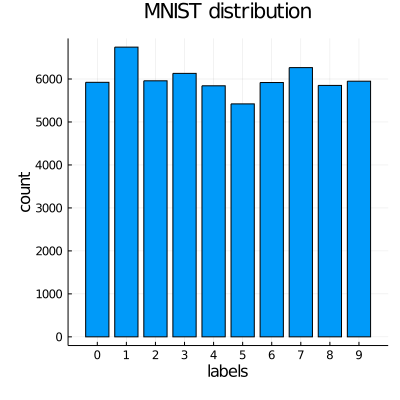

In [7]:
# check for unique labels
l = unique(labels)
sort!(l)
display(l')

# distribution of labels
c = countmap(labels)
x = [i for i in keys(c)]
y = [i for i in values(c)]

b = bar(x, y, xticks = l, label = false)
b = bar!(xlabel = "labels", ylabel = "count", title = "MNIST distribution", size=(400,400))

In [25]:
# split trainset testset
trainX = images[1:50000]
trainY = labels[1:50000]
testX  = images[50001:60000]
testY  = labels[50001:60000];

In [23]:
# functions for feature extraction
meanIntensity(img) = mean(Float64.(img))

function hSymmetry(img)
    imgFloat = Float64.(img)
    imgReverse = reverse(imgFloat, dims=1)
    return -mean( abs.(imgFloat - imgReverse) )
end

#teste das funções
meanIntensity(images[1]), hSymmetry(images[1])

(0.13768007202881152, -0.17842136854741897)

In [51]:
trainMeanX = [meanIntensity(i) for i in trainX]
trainHsymX = [hSymmetry(i)     for i in trainX]
trainFeatX = hcat(trainMeanX, trainHsymX)

testMeanX = [meanIntensity(i) for i in testX]
testHsymX = [hSymmetry(i)     for i in testX]
testFeatX = hcat(testMeanX, testHsymX);
